In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes as ax
import pyodbc
import math
import os
import datetime as dt
import sidetable as stb

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

Ideas para mejorarlo: centrarse en socios que se dieron de baja el ultimo mes/trimestre
Variables: probo granel? probo impulsivo? probo frizzio?
cantidad canjes

#### Importo datos

Voy a analizar qué pasó en los 12 meses anteriores a los socios que abandonaron en el mes pasado (a mes vencido)

Entonces, quiero tomar los datos de todos los socios que consumieron o no en los ultimos 12 meses. De ahí voy a quitar a los socios que abandonaron antes de los 12 meses y quedarme solo con los que abandonaron en el mes anterior y con los que no abandonaron pero sí compraron en este período de tiempo

In [3]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """

DECLARE @desde DATE SET @desde = DATEADD(mm, DATEDIFF(m,0,GETDATE())-13,0) --me devuelve el dia 1 de 13 meses antes
DECLARE @hasta DATE SET @hasta = DATEADD(mm, DATEDIFF(m,0,GETDATE())-1,0) --me devuelve el dia 1 del mes anterior

SELECT
sc.CustomerId, 
ISNULL(sum(s.ProductWeightGrams* s.Amount * 0.001),0) 'kilos',
DATEDIFF(MONTH,c.ActivatedDate,getdate()) 'meses_desde_alta',
DATEDIFF(YY, C.BirthDate, GETDATE()) - CASE WHEN (MONTH(C.BirthDate) > MONTH(GETDATE())) OR (MONTH(C.BirthDate) = MONTH(GETDATE()) AND DAY(C.BirthDate) > DAY(GETDATE())) THEN 1 ELSE 0 END 'Age',
ISNULL(DATEDIFF(MONTH,max(s.SaleDate),getdate()),0) 'meses_desde_ult_compra',

ISNULL(COUNT(DISTINCT s.SaleId),0) 'cantidad_compras',
ISNULL(COUNT(DISTINCT s.PromotionId),0) 'cantidad_promos',
ISNULL(COUNT(DISTINCT s.ProductId),0) 'cantidad_productos',
case when seg.categoria = 'ABANDONO' then 1 else 0 end 'abandono',
case when c.GenderCode = 'Female' then 0 else 1 end 'genero',

case when sc.CustomerId IN (SELECT sc.CustomerId FROM dbo.SaleCustomer sc
							INNER JOIN dbo.Sale s ON s.SaleId = sc.SaleId
							INNER JOIN dbo.powerbi_franquicias_ventas_articulos art ON art.Codigo = s.ProductId
							where s.SaleDate BETWEEN @desde and @hasta
							AND art.idCategoria = 3
							AND art.ptipo = 'H'
							GROUP BY sc.CustomerId ) then 1 else 0 end AS 'consumio_alimentos',

case when sc.CustomerId IN (SELECT sc.CustomerId FROM dbo.SaleCustomer sc
							INNER JOIN dbo.Sale s ON s.SaleId = sc.SaleId
							INNER JOIN dbo.powerbi_franquicias_ventas_articulos art ON art.Codigo = s.ProductId
							where s.SaleDate BETWEEN @desde and @hasta
							AND art.Familia = 'Impulsivos'
							AND art.ptipo = 'H'
							GROUP BY sc.CustomerId ) then 1 else 0 end AS 'consumio_impulsivo',

case when sc.CustomerId IN (SELECT sc.CustomerId FROM dbo.SaleCustomer sc
							INNER JOIN dbo.Sale s ON s.SaleId = sc.SaleId
							INNER JOIN dbo.powerbi_franquicias_ventas_articulos art ON art.Codigo = s.ProductId
							where s.SaleDate BETWEEN @desde and @hasta
							AND art.Familia = 'Granel'
							AND art.ptipo = 'H'
							GROUP BY sc.CustomerId ) then 1 else 0 end AS 'consumio_granel',

case when sc.CustomerId IN (SELECT e.CustomerId FROM dbo.Exchange e 
							where e.ExchangeDate BETWEEN @desde and @hasta
							GROUP BY e.CustomerId ) then 1 else 0 end AS 'canjeo'


FROM dbo.Customer c
LEFT JOIN dbo.SaleCustomer SC ON sc.CustomerId = c.CustomerId
LEFT JOIN dbo.Sale s ON s.SaleId=sc.SaleId
LEFT JOIN dbo.Clientes_Segmentacion_2022 seg ON c.CustomerId = seg.CustomerId
LEFT JOIN dbo.Exchange e ON e.CustomerId = c.CustomerId

WHERE s.SaleDate BETWEEN @desde and @hasta

GROUP BY sc.CustomerId,seg.categoria,c.GenderCode, c.BirthDate, c.ActivatedDate
HAVING ISNULL(COUNT(DISTINCT s.SaleId),0) > 0
"""
df = pd.read_sql(sql, conn)
df.head()

,CustomerId,kilos,meses_desde_alta,Age,meses_desde_ult_compra,cantidad_compras,cantidad_promos,cantidad_productos,abandono,genero,consumio_alimentos,consumio_impulsivo,consumio_granel,canjeo
0,273AFE21-79E8-CC3A-AAF6-08D0C0CE8984,1.640,102,37,2,2,0,4,0,0,0,0,1,0
1,D1C0D365-6970-C40B-A6E6-08D0BD70A3EB,75.585,103,47,3,4,1,15,0,1,1,1,0,0
2,D29ED1F9-7C81-C0F3-23AA-08D0BF502D86,40.000,103,29,3,5,0,5,0,1,0,1,1,0
3,24FB0387-327A-CD4B-5792-08D0C3298D3B,164.224,102,48,2,21,0,14,0,0,1,1,1,1
4,6ACC86A5-45BC-C851-BE13-08D0BF45D4BD,1.470,103,38,5,2,0,4,0,0,0,1,1,0


In [3]:
DB = {'servername': '',
      'database': '',
      'usuario' :'',
      'contraseña':'',
      'Encrypt':'yes',
      'TrustServerCertificate':'no',
      'Connection Timeout':'30'}

# create the connection
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] +\
                      ';UID=' + DB['usuario'] + ';PWD='+ DB['contraseña'] + ';Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30')

# query db
sql = """

SELECT sc.CustomerId, case when seg.categoria = 'ABANDONO' then 1 else 0 end 'target'
FROM dbo.SaleCustomer sc
INNER JOIN dbo.Sale s ON s.SaleId = sc.SaleId
INNER JOIN dbo.clientes_segmentacion_2022 seg ON seg.CustomerId = sc.CustomerId
GROUP BY sc.CustomerId, seg.categoria
HAVING DATEADD(year, 1, max(s.SaleDate)) > '2022-04-30'
"""
df = pd.read_sql(sql, conn)
df.head()

,CustomerId,kilos,meses_desde_alta,Age,meses_desde_ult_compra,cantidad_compras,cantidad_promos,cantidad_productos,abandono,genero,consumio_alimentos,consumio_impulsivo,consumio_granel,canjeo
0,273AFE21-79E8-CC3A-AAF6-08D0C0CE8984,1.640,102,37,2,2,0,4,0,0,0,0,1,0
1,D1C0D365-6970-C40B-A6E6-08D0BD70A3EB,75.585,103,47,3,4,1,15,0,1,1,1,0,0
2,D29ED1F9-7C81-C0F3-23AA-08D0BF502D86,40.000,103,29,3,5,0,5,0,1,0,1,1,0
3,24FB0387-327A-CD4B-5792-08D0C3298D3B,164.224,102,48,2,21,0,14,0,0,1,1,1,1
4,6ACC86A5-45BC-C851-BE13-08D0BF45D4BD,1.470,103,38,5,2,0,4,0,0,0,1,1,0


Primer filtro para saber que un socio nos abandonó es aquel que nunca compró. La pregunta que tengo que resolver es: ¿Cuántos días pasan entre la activacion y la primera compra en los socios que nos abandonan?

In [29]:
df['porcentaje_promos'] = np.where(df.cantidad_compras==0,0,df.cantidad_promos / df.cantidad_compras)

In [37]:
df.columns.tolist()

['CustomerId',
 'kilos',
 'meses_desde_alta',
 'Age',
 'meses_activo',
 'meses_desde_ult_compra',
 'cantidad_compras',
 'cantidad_promos',
 'cantidad_productos',
 'abandono',
 'genero',
 'dias_entre_alta_y_compra',
 'fecha_activacion',
 'fecha_primera_compra',
 'fecha_ultima_compra',
 'porcentaje_promos']

### Hago un arbol de decisión para entender cómo reacciona el modelo

In [61]:
X = df.drop(columns = ['meses_desde_ult_compra',"abandono",'CustomerId', 'fecha_activacion','fecha_primera_compra','fecha_ultima_compra'])
y = df.abandono
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [62]:
print(X.shape)
print(y.shape)

(4133659, 10)
(4133659,)


#### Armo el árbol de decisión

In [63]:
#Inicializo el arbol. En este caso utilizo todos los valores por defecto
treeModel = tree.DecisionTreeClassifier()
#Entreno el modelo con la informacion de train
treeModel.fit(X_train, y_train)

DecisionTreeClassifier()

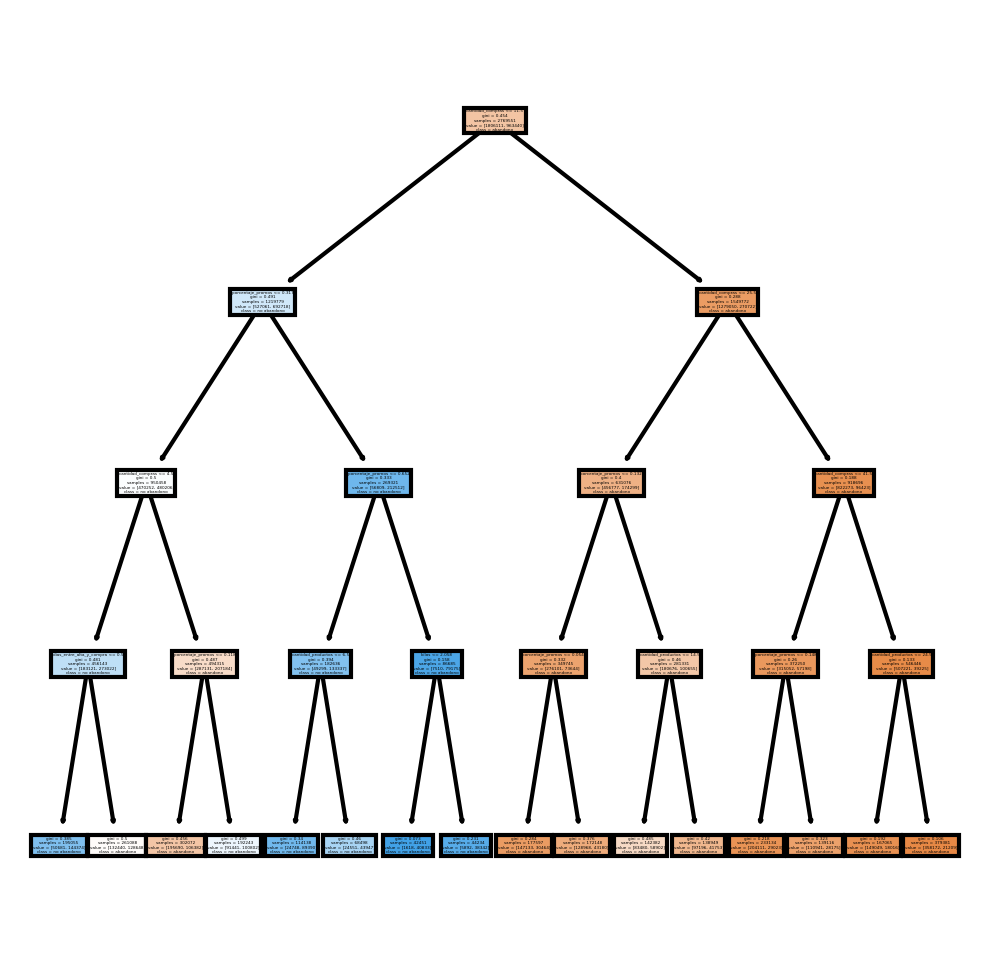

In [41]:
#Imprimo el arbol, ademas puedo guardarlo en un archivo para poder visualizarlo en otro lugar o utilizar la imagen en una 
#presentacion
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(treeModel,
               feature_names = X_train.columns, 
               class_names=["abandono", "no abandono"],
               filled = True);
#fig.savefig('C:\Users\pnovero\Documents\Extractos DW\arbolProfundidad3.png')

In [64]:
predictedValues = treeModel.predict(X_test)
accuracy_score(y_test, predictedValues)

0.9956117844041674

In [65]:
r = tree.export_text(treeModel, feature_names=list(X_train.columns))
print(r)

|--- meses_activo <= 39.50
|   |--- meses_desde_alta <= 42.50
|   |   |--- meses_activo <= 22.50
|   |   |   |--- meses_desde_alta <= 23.50
|   |   |   |   |--- porcentaje_promos <= 0.62
|   |   |   |   |   |--- meses_desde_alta <= 12.50
|   |   |   |   |   |   |--- meses_desde_alta <= 11.50
|   |   |   |   |   |   |   |--- cantidad_compras <= 1.50
|   |   |   |   |   |   |   |   |--- kilos <= 2.10
|   |   |   |   |   |   |   |   |   |--- dias_entre_alta_y_compra <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- meses_desde_alta <= 6.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |   |--- meses_desde_alta >  6.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 18
|   |   |   |   |   |   |   |   |   |--- dias_entre_alta_y_compra >  0.50
|   |   |   |   |   |   |   |   |   |   |--- kilos <= 0.41
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 14
|   |   |   |   |

### Curva ROC

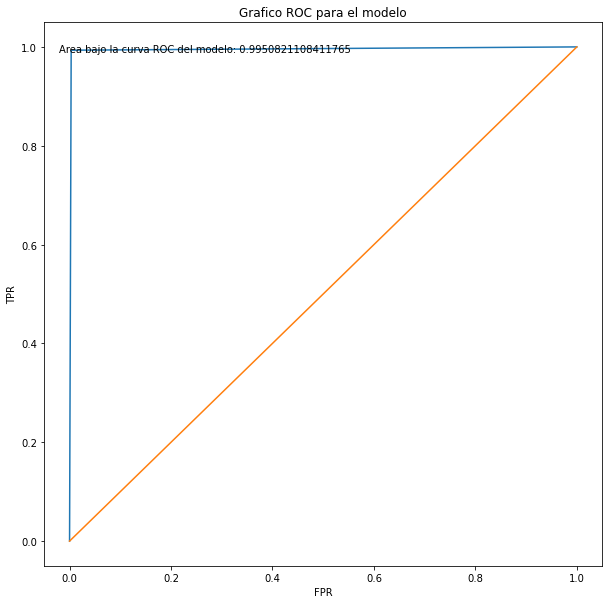

In [66]:
areaBajoCurvaRoc = roc_auc_score(y_test, predictedValues)
fpr, tpr, _ = roc_curve(y_test, predictedValues)
plt.figure(figsize=(10,10))
plt.title("Grafico ROC para el modelo")
plt.plot(fpr, tpr)
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.annotate('Area bajo la curva ROC del modelo: {}'.format(areaBajoCurvaRoc), (-0.02,0.99))
plt.show()